# Checking The Overfitting

- Breast Cancer Classification modeli adı verilen bir model geliştirilmiştir. İlgili mühendis bu modelin accuracy değerinin yüzde 98 olduğunu iddia etmektedir. Ancak modelin hastalarımız ile ilgili yaptığı yanlış tahminler hastanemizi sıkıntıya sokmaktadır :)

- Bu modeli tekrar geliştiriniz ve sonuçları yorumlayınız.

Logistic regression bölümünde elde ettiğimiz model accuracy değeri yüzde 98 idi. Bu durum bize aşırı öğrenme problemine düşebileceğimizi düşündürmüştü. Mühendisimizin günahını da alıyor olabiliriz. Bilmiyoruz.

Bu sebeple aşırı öğrenme önlemleri alarak yeni bir model geliştirmemiz gerekiyor.

Bu veri setini tekrar modelleyiniz.

Dikkat edilmesi gerekenler:

- sklearn içerisinde yer alan breast cancer veri setini kullanınız. (from sklearn.datasets import load_breast_cancer)

- Veri ön işleme adımında amelasyon yapılabilir. Fonksiyon yazılmasına gerek yok.

- Tensorflow dataset için tanımladığımız fonksiyonu kullanınız ve batch_size'ı 32 yapınız.

- 1 gizli katmanlı basit bir model oluşturunuz. Nöron sayısını istediğiniz gibi tercih edebilirsiniz.

- Aşırı öğrenme problemine karşı uygun katman yapılarını ve callback'i kullanınız.

- Model compile bölümünde SGD'yi direkt kullanınız yani compile içinde optimizer="SGD" şeklinde kullanınız.

- Overfitting'den şüphelendiğimiz için early stopping'de küçük bir değer giriniz.

- En iyi epoch sonucunu yorumlayınız.

- Loss eğrisini yorumlayınız.

- İfade edilmeyen konularda tercih size bırakılmıştır.


In [ ]:
import keras
import tensorflow as tf
print("Keras Current Version:", keras.__version__, "Tensorflow Current Version:", tf.__version__)

Keras Current Version: 3.3.3 Tensorflow Current Version: 2.16.1


In [ ]:
# !pip uninstall tf-keras

In [ ]:
# !pip install tensorflow==2.16.1

# Imports and Settings

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization

random.seed(46)
np.random.seed(46)
tf.random.set_seed(46)


# Functions

In [ ]:
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()


def get_best_epoch_details(history):
    val_losses = history.history['val_loss']
    min_val_loss_index = val_losses.index(min(val_losses))
    best_epoch = min_val_loss_index + 1

    epoch_details = {}
    for key in history.history.keys():
        epoch_details[key] = history.history[key][min_val_loss_index]

    epoch_details['best_epoch'] = best_epoch
    return epoch_details

def prepare_datasets(X_train, X_val, y_train, y_val, batch_size=None):

    if batch_size is None:
        batch_size = len(X_train)

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(batch_size)

    return train_dataset, val_dataset


# Data Preprocess, Train Validation and Tensorflow Dataset

# Task 1: Veri setini yükleyiniz ve X ve y'yi alınız.

In [ ]:
data = load_breast_cancer()

X = data.data
y = data.target

# Task 2: Train Validasyon seti ayrımını yapınız

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Task 3: X_train ve X_val setlerini standart scaler'dan geçiriniz

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Task 4: Tensorflow Dataset oluşturunuz

In [ ]:
train_ds, val_ds = prepare_datasets(X_train, X_val, y_train, y_val, batch_size=32)

# Model

# Task 5: Model yapısını aşırı öğrenme için uygun katmanları da kullanarak oluşturunuz

In [ ]:
model = Sequential([
    Input(shape=(train_ds.element_spec[0].shape[1],)),

    Dense(50, activation='relu', kernel_regularizer=l2(0.001)), #l2 düzenlileştirme parametresi kullanıyoruz.

    BatchNormalization(), # daha stabil bir öğrenme için aktivasyonları standartlaştırıyoruz.

    Dropout(0.5), # dropout katmanı ekliyoruz.

    Dense(1, activation='sigmoid')
])


# Task 6: Modeli SGD ile, binary_crossentropy ve accuracy, AUC değerleri ile compile ediniz.

In [ ]:
model.compile(optimizer="SGD", # sgd'yi ön tanımlı değerleri ile kullanıyoruz.
              loss="binary_crossentropy",
              metrics=["accuracy", "AUC"])



# Task 7: Early stopping callback'i tanımlayınız.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, # risk almamak adına patience'ı küçük tutuyoruz.
    verbose=1,
    restore_best_weights=True)

# Task 8: Modeli train ediniz

In [ ]:
history = model.fit(train_ds,
            epochs=1000,
            validation_data=val_ds,
            verbose=1,
            callbacks=[early_stopping])

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.7577 - accuracy: 0.6895 - loss: 0.6782 - val_AUC: 0.9665 - val_accuracy: 0.8421 - val_loss: 0.4578
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8966 - accuracy: 0.8237 - loss: 0.4694 - val_AUC: 0.9808 - val_accuracy: 0.9064 - val_loss: 0.3936
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9283 - accuracy: 0.8569 - loss: 0.3783 - val_AUC: 0.9870 - val_accuracy: 0.9240 - val_loss: 0.3513
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9276 - accuracy: 0.8590 - loss: 0.3771 - val_AUC: 0.9893 - val_accuracy: 0.9357 - val_loss: 0.3156
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9444 - accuracy: 0.8972 - loss: 0.3413 - val_AUC: 0.9905 - val_accuracy: 0.9415 - val_loss: 0.2908
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9444 - accuracy: 0.8839 - loss: 0.3233 - val_AUC: 0.9913 - val_accuracy: 0.9474 - val_loss: 0.2672
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━

# Task 9: En iyi epoch değerlerini getiriniz ve yorumlayınız.

In [ ]:
best_epoch_details = get_best_epoch_details(history)
print(f"Best epoch details: {best_epoch_details}")

Best epoch details: {'AUC': 0.9888278245925903, 'accuracy': 0.9547738432884216, 'loss': 0.1492176502943039, 'val_AUC': 0.998236358165741, 'val_accuracy': 0.9824561476707458, 'val_loss': 0.09957513213157654, 'best_epoch': 82}


# Task 10: Train history'sini görselleştiriniz ve yorumlayınız

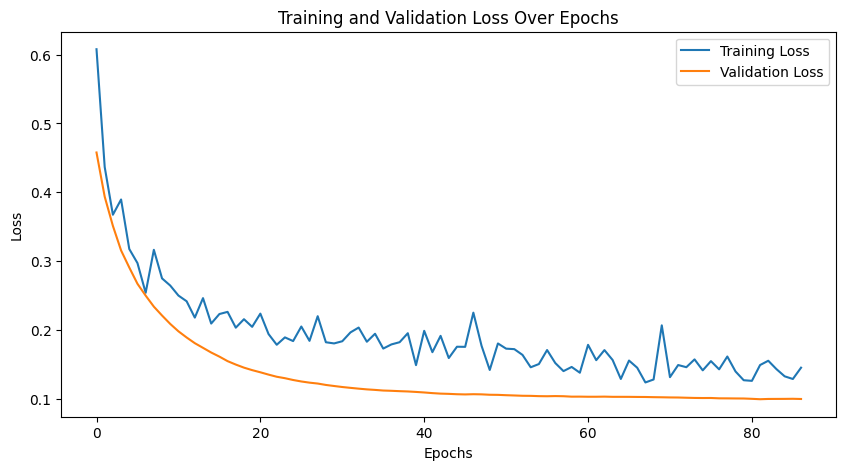

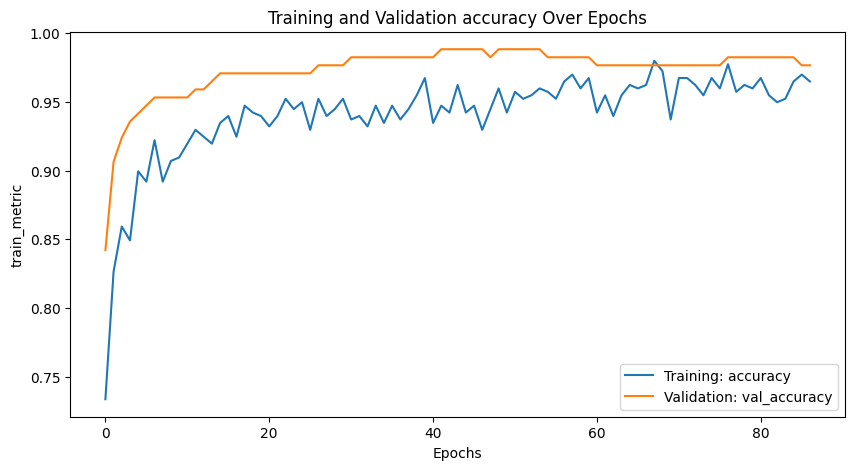

In [ ]:
plot_training_history(history)

# Task 11: Modelin aşırı öğrenme durumu ile ilgili ne düşünüyorsunuz?